In [ ]:
# pip install xgboost

In [ ]:
# y = indicates if the firm has defaulted by time t 

In [2]:
import datetime
import time
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from statsmodels.gam.api import GLMGam, BSplines #GLMGam Generalized Additive Models (GAM)
from xgboost import XGBClassifier
from sklearn.svm import SVC
import statsmodels.api as sms
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

In [24]:
train = pd.read_csv("/Users/khevnaparikh/Desktop/Finance/Probability-of-Default-/train.csv")
print("Raw data:", train.shape)

Raw data: (1023552, 44)


In [25]:
engineered = pd.DataFrame([], index=train.index)

engineered["cf_to_debt"] = train.cf_operations / (train.debt_st + train.debt_lt)
engineered["debt_ratio"] = (train.debt_st + train.debt_lt) / train.asst_tot
engineered['ebitda_ta'] = train.ebitda / train.asst_tot
engineered['wc_ta'] = train.wc_net / train.asst_tot
# engineered['profit'] = train.profit # above 5 variables auc score = .80
engineered['log_AP_st'] = np.log(train.AP_st)
engineered['log_current_assets'] = train.debt_st / train.asst_current

/Users/khevnaparikh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/khevnaparikh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [29]:
engineered.describe()[2:]

,cf_to_debt,debt_ratio,ebitda_ta,wc_ta,log_AP_st,log_current_assets
std,NaN,0.345721,1.483310,0.353475,NaN,NaN
min,-inf,-0.414003,-1307.371779,-56.144887,-inf,-36.332004
25%,0.001893,0.489164,0.012229,-0.028460,11.407576,0.468847
50%,0.032834,0.746079,0.042773,0.101744,13.134754,0.806976
75%,0.097535,0.909270,0.082189,0.325414,14.124722,1.080004
max,inf,97.077776,9.081566,5.343304,22.137673,inf


In [2]:
#function to handle all the preprocessing
def preprocess_data(df): 
    
    #pandas indexes automatically, so we remove the unnamed columns, 
    #we remove eqty_corp_family_tot since all rows are nans
    #fiscal year contains the same information as stmt_date so we will remove this as well
    df.drop(columns = ['Unnamed: 0', 'eqty_corp_family_tot', 'stmt_date'], inplace=True)
    
    #convert data types of certain variables
    df['def_date'] = pd.to_datetime(df["def_date"] , format = "%d/%m/%Y")
    df['ateco_sector'] = df['ateco_sector'].astype(int)
    
    # Sort the data by company ID and fiscal year to prevent potential look-ahead bias
    df.sort_values(["fs_year", "id"], inplace=True)
    df.reset_index(drop=True , inplace=True)
    
    #create a target variable 87e=True)
    df['target'] = np.logical_and(df["def_date"].notna(), 
                               df["fs_year"] + 1 >= df["def_date"].dt.year).astype(int)

#     df = df.join(pd.get_dummies(df['legal_struct']))
    
    #Because the (fiscal year, company ID) pair uniquely identifies each row, make it the index    
    df.set_index(["fs_year", "id"], inplace=True)
    
    print("Preprocessed data:", df.shape)
    
    return df 
    

In [ ]:
# train = pd.read_csv("/Users/khevnaparikh/Desktop/Finance/Probability-of-Default-/train.csv")

In [3]:
# tmp = train.groupby('target').median().T
# tmp['pct_diff'] = tmp.pct_change(axis='columns')[1]
# tmp.sort_values(by=['pct_diff'])

In [4]:
# fill in Nans using interpolation 
def impute(df):
    fields = ['wc_net', 'asst_tot', 'ebitda', 'eqty_tot', 'cf_operations', 
              'taxes','debt_st', 'debt_lt', 'debt_bank_lt', 'liab_lt', 
              'liab_lt_emp', 'AP_lt', 'roe', 'roa', 'prof_financing', 
              'exp_financing']
    print("Number of fields to impute:", len(fields))
    
    firm_indices = [x[1] for x in df.index]
    companies = np.unique(firm_indices)

    # Impute NaNs based on interpolation method
    map(lambda firm: df.loc[firm_indices == firm, fields].interpolate(
    limit_direction="forward", inplace=True), companies)
    
    return df

In [107]:
def engineer_features(df):
    # Create a dataframe of features that will be used by the model
    engineered = pd.DataFrame([], index=df.index)

    # Calculate features
    engineered["cf_to_debt"] = df.cf_operations / (df.debt_st + df.debt_lt)
    engineered["debt_ratio"] = (df.debt_st + df.debt_lt) / df.asst_tot
    engineered['ebitda_ta'] = df.ebitda / df.asst_tot
    engineered['wc_ta'] = df.wc_net / df.asst_tot
    engineered['profit'] = df.profit # above 5 variables auc score = .80
    engineered['log_AP_st'] = np.log(df.AP_st)
    engineered['log_current_assets'] = df.debt_st / df.asst_current
#     engineered['target']  = df.target
    
#     engineered['cf_operations'] =  np.log(df.cf_operations)
    engineered['roe'] = np.log(df.roe)
    engineered['roa'] = np.log(df.roa)
    engineered['eqty_tot'] = np.log(df.eqty_tot)
    engineered['asst_tang_fixed'] = np.log(df.asst_tang_fixed)
#     engineered['ebitda'] = np.log(df.ebitda)
    
    engineered['target']  = df.target
    
    
#     engineered['debt_st_curr_asset'] = df.debt_st / df.asst_current
        #auc w/profit & above variable - .68
        #auc w/o profit & above variable - .75

    
    
#firm size
#geographic location - make no difference 
#defualts for one year - examin short term debt/libabilites/assets 
#one hot encode - legal structure"", 
    

    # Delete rows that have any undefined ratios (infinity or NaN)
    # The mask is an array of booleans, such that if mask[i] = True, it means
    # we delete row i.
    
    is_inf = np.isinf(engineered)
    is_nan = np.isnan(engineered)
    mask = np.any(np.logical_or(is_inf, is_nan), axis=1)
    engineered.drop(index=engineered.index[mask], inplace=True)
    
    return engineered


In [108]:
def walk_forward(df): 
    """
    Walk-forward algorithm:

    1) Train the model on all observations from the beginning up until year t.
    2) Use the trained model to make predictions on observations from year t + 1.
    3) Save the predictions in an array.
    4) Increment t by 1 and repeat steps 1 to 3.
    """
    
    features = df.iloc[:,:9]
    target = df.iloc[:,9]
    
    fs_year = features.index.map(lambda pair: pair[0])
    years = np.unique(fs_year)[:-1]
    

    # Select part of the data for training
    X_trains = map(lambda t: features[fs_year <= t], years)
    y_trains = map(lambda t: target[fs_year <= t], years)

    # Train models
    models = map(lambda X, y: LogisticRegression().fit(X, y), X_trains, y_trains)
    
    # Select part of the data for testing
    X_tests = map(lambda t: features[fs_year == t+1], years)
    y_tests = map(lambda t: target[fs_year == t+1], years)
    
    # Ground truth
    true = np.hstack(list(y_tests))

    # Compute predictions
    pred = map(lambda model, X: model.predict_proba(X), models, X_tests)
    pred = np.concatenate(list(pred))
    return true, pred

In [109]:
train = pd.read_csv("/Users/khevnaparikh/Desktop/Finance/Probability-of-Default-/train.csv")
print("Raw data:", train.shape)

def harness(df):
    preprocessed_df = preprocess_data(df)
    imputed_df = impute(preprocessed_df)
    engineered_df = engineer_features(imputed_df)
    true, pred = walk_forward(engineered_df)
    print(roc_auc_score(true, pred[:,1]))
    return preprocessed_df

df = harness(train)

Raw data: (1023552, 44)
Preprocessed data: (1023552, 40)
Number of fields to impute: 16


/Users/khevnaparikh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/khevnaparikh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/khevnaparikh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/khevnaparikh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/khevnaparikh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/khevnaparikh/opt/ana

0.7313459283394587


In [4]:
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot


dataset = pd.read_csv("/Users/khevnaparikh/Desktop/Finance/Probability-of-Default-/train.csv")
dataset['def_date'] = pd.to_datetime(dataset["def_date"] , format = "%d/%m/%Y")


dataset['target'] = np.logical_and(dataset["def_date"].notna(), 
                               dataset["fs_year"] + 1 >= dataset["def_date"].dt.year).astype(int)

dataset.sort_values(["fs_year", "id"], inplace=True)
dataset.reset_index(drop=True , inplace=True)

dataset.set_index(["fs_year", "id"], inplace=True)


In [5]:
dataset.drop(columns = ['Unnamed: 0', 'eqty_corp_family_tot', 'stmt_date'], inplace=True)


In [6]:
dataset.head()

HQ_city legal_struct  ateco_sector def_date  \
fs_year id                                                     
2007    520288      28.0          SRL          14.0      NaT   
        1650282     27.0          SRL          25.0      NaT   
        2040061      6.0          SPA          46.0      NaT   
        2340420     42.0          SRL          47.0      NaT   
        2890408     40.0          SPA          43.0      NaT   

                 asst_intang_fixed  asst_tang_fixed  asst_fixed_fin  \
fs_year id                                                            
2007    520288            126603.0        1127807.0           620.0   
        1650282           881316.0        1128642.0          8231.0   
        2040061            23162.0        1524285.0             1.0   
        2340420                0.0          58749.0             0.0   
        2890408          2409029.0       31875124.0      59321193.0   

                 asst_current          AR  cash_and_equiv  ...      taxes  \
fs_year id                                                 ...              
2007    520288       484753.0    455224.0         14279.0  ...    92192.0   
        1650282     9409128.0   7315239.0       2059048.0  ...   759122.0   
        2040061     1410043.0    639403.0        225421.0  ...   198366.0   
        2340420     1994918.0    747994.0         65405.0  ...    42062.0   
        2890408   144525085.0  97473373.0       8899382.0  ...  4384530.0   

                    profit  days_rec      ebitda   roa    roe      wc_net  \
fs_year id                                                                  
2007    520288     36733.0       NaN    153060.0  6.20  52.43   -317007.0   
        1650282   506075.0     -3.19   1097368.0  6.29  16.18   1584139.0   
        2040061    74090.0    163.80    376754.0  8.45   7.22    373261.0   
        2340420     7679.0       NaN     61648.0  2.17   0.73   1124550.0   
        2890408 -3292829.0    261.37  15242060.0  4.51 -18.36 -29858237.0   

                 margin_fin  cf_operations  target  
fs_year id                                          
2007    520288   -1184970.0        80039.0       0  
        1650282   1108702.0       868088.0       0  
        2040061   -521839.0       195790.0       0  
        2340420    993363.0        24385.0       0  
        2890408 -75667307.0      1173191.0       0  

[5 rows x 40 columns]

In [7]:
dataset['target']

fs_year  id         
2007     520288         0
         1650282        0
         2040061        0
         2340420        0
         2890408        0
                       ..
2012     97696630017    0
         98002050783    0
         98002670176    0
         98111210179    0
         98111220178    0
Name: target, Length: 1023552, dtype: int64

In [8]:
X = dataset.iloc[:,4:-1]
y = dataset['target']

In [9]:
tmp = np.log(X)

/Users/khevnaparikh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/khevnaparikh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [10]:
model = XGBClassifier().fit(X, y)

In [11]:
model.feature_importances_

array([0.01719602, 0.04019621, 0.01610622, 0.01459845, 0.02038657,
       0.01545832, 0.01763894, 0.17341158, 0.01499201, 0.02054923,
       0.02719268, 0.01615885, 0.00958269, 0.01151626, 0.01739936,
       0.01268457, 0.01594928, 0.02113455, 0.01541776, 0.01401637,
       0.01552432, 0.0160467 , 0.02015803, 0.01503719, 0.01302326,
       0.01608853, 0.02341824, 0.01994713, 0.01354413, 0.03624264,
       0.06027418, 0.16582595, 0.01668706, 0.01415938, 0.04243732],
      dtype=float32)

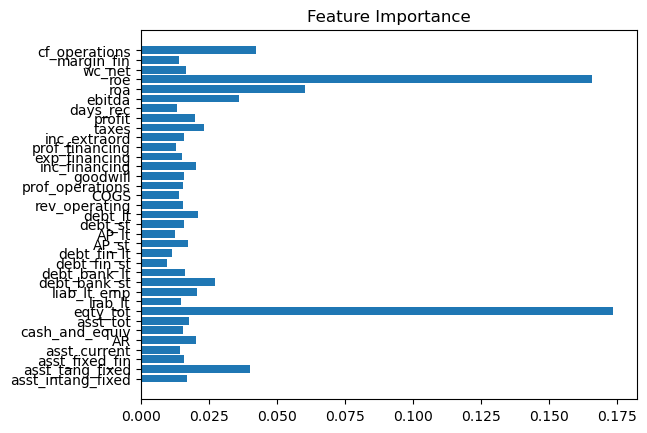

<Figure size 2000x2000 with 0 Axes>

In [19]:
# plot
plt.barh(X.columns, model.feature_importances_, )
plt.title("Feature Importance")
plt.figure(figsize=(20, 20))
plt.show()

In [49]:
X.columns

Index(['asst_intang_fixed', 'asst_tang_fixed', 'asst_fixed_fin',
       'asst_current', 'AR', 'cash_and_equiv', 'asst_tot', 'eqty_tot',
       'liab_lt', 'liab_lt_emp', 'debt_bank_st', 'debt_bank_lt', 'debt_fin_st',
       'debt_fin_lt', 'AP_st', 'AP_lt', 'debt_st', 'debt_lt', 'rev_operating',
       'COGS', 'prof_operations', 'goodwill', 'inc_financing', 'exp_financing',
       'prof_financing', 'inc_extraord', 'taxes', 'profit', 'days_rec',
       'ebitda', 'roa', 'roe', 'wc_net', 'margin_fin', 'cf_operations'],
      dtype='object')

In [ ]:
['cf_operations', 'roe', 'roa', 'ebitda', 'eqty_tot', 'asst_tang_fixed']